# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [1]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [2]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

wandb: Currently logged in as: juliachirkova. Use `wandb login --relogin` to force relogin


True

In [3]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
#import pytorch_lightning as pl
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

from pathlib import Path
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader, IMG_EXTENSIONS
from typing import Tuple, Any
import cv2

In [4]:
from pytorch_lightning import callbacks

In [5]:
from pytorch_lightning.callbacks import LearningRateFinder

In [6]:
import albumentations
import albumentations.pytorch

In [7]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [8]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-11-12 19:16:46--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-11-12 19:16:46--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7d6cbb5fcbde1ff8cca7fe0fae.dl.dropboxusercontent.com/cd/0/get/CHZqXrKfXW06p3KPA39tHEdpvkhPdTf9MdwNVn25114p0_Vq-UGnJaDLIRUGmB3s0ZJDKYDPMDJ8qozvE1ymP9PjxwF26WTetr-1IgFQp7IerrFnBWFucRynaxV02S5hBI3WjyoAUGxQAGNBRocY57MO/file?dl=1# [following]
--2023-11-12 19:16:47--  https://uc7d6cbb5fcbde1ff8cca7fe0fae.dl.dropboxusercontent.com/cd/0/get/CHZqXrKfXW06p3KPA39tHEdpvkhPdTf9MdwNVn25114p0_Vq-UGnJaDLIRUGmB3s0ZJDKYDPMDJ8qozvE1ymP9PjxwF26WTetr-1

In [9]:
from torchvision.datasets.folder import default_loader

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

Поскольку использовала библиотеку с аугументациями (которая была дана в условиях), то обычный ImageFolder перестал работать и я добавила новый класс для чтения: https://stackoverflow.com/questions/69151052/using-imagefolder-with-albumentations-in-pytorch


In [10]:
class AlbumentationsImageFolder(ImageFolder):
    def __init__(
        self,
        root: str,
        transform = None,
        loader = default_loader,
    ):
        super(ImageFolder, self).__init__(
            root,
            loader,
            IMG_EXTENSIONS,
            transform=transform,
        )
        self.imgs = self.samples

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, target

    def __len__(self) -> int:
        return len(self.samples)

Аугментации добавила исходя из документации, потом вычислила среднее и стандартное отклонение для валидации и тренировочной выборки, взяла отсюда https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/14

In [11]:
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = albumentations.Compose([
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1),
                          albumentations.Rotate(p=1),
                          albumentations.ShiftScaleRotate(p=1)
    ], p=1),
    albumentations.pytorch.transforms.ToTensorV2()
])

val_transform = albumentations.Compose([
    albumentations.pytorch.transforms.ToTensorV2()
])

train_dataset = AlbumentationsImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = AlbumentationsImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=2)

In [12]:
from PIL import ImageStat

class Stats(ImageStat.Stat):
    def __add__(self, other):
        # add self.h and other.h element-wise
        return Stats(list(np.add(self.h, other.h)))

In [13]:
statistics = None
toPIL=transforms.ToPILImage()

for data, _ in train_dataloader:
    for b in range(data.shape[0]):
        if statistics is None:
            print(type(toPIL(data[b])))
            statistics = Stats(toPIL(data[b]))
        else:
            statistics += Stats(toPIL(data[b]))
print(f'mean:{statistics.mean}, std:{statistics.stddev}')

<class 'PIL.Image.Image'>
mean:[122.54783807861328, 114.23272784179687, 101.28037157470703], std:[69.34874329813721, 67.36654988860741, 70.67639412245545]


In [14]:
statisticsval = None
toPIL=transforms.ToPILImage()

for data, _ in val_dataloader:
    for b in range(data.shape[0]):
        if statisticsval is None:
            print(type(toPIL(data[b])))
            statisticsval = Stats(toPIL(data[b]))
        else:
            statisticsval += Stats(toPIL(data[b]))
print(f'mean:{statisticsval.mean}, std:{statisticsval.stddev}')

<class 'PIL.Image.Image'>
mean:[123.00136350097657, 114.62166755371094, 101.51094846191407], std:[70.49869171770116, 68.62454993010803, 72.02543615606243]


In [15]:
means = tuple(x/255 for x in statistics.mean)
stds = tuple(x/255 for x in statistics.stddev)
means, stds # for train_dataloader

((0.48057975717103246, 0.44797148173253676, 0.39717792774394917),
 (0.2719558560711263, 0.2641825485827742, 0.27716232989198214))

In [16]:
meansval = tuple(x/255 for x in statisticsval.mean)
stdsval = tuple(x/255 for x in statisticsval.stddev)
meansval, stdsval # for val_dataloader

((0.4823582882391238, 0.4494967355047488, 0.39808215083103554),
 (0.2764654577164751, 0.269115882078855, 0.28245269080808794))

In [17]:
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = albumentations.Compose([
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1),
                          albumentations.Rotate(p=1),
                          albumentations.ShiftScaleRotate(p=1)
    ], p=1),
    albumentations.Normalize(means, stds),
    albumentations.pytorch.transforms.ToTensorV2()
])

val_transform = albumentations.Compose([
    albumentations.Normalize(meansval, stdsval),
    albumentations.pytorch.transforms.ToTensorV2()
])

train_dataset = AlbumentationsImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = AlbumentationsImageFolder('dataset/dataset/val', transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=2)

Вообще изначально пыталась сделать так (в описании будет ссылка на эксперименты)

In [ ]:
# YOU CAN DEFINE AUGMENTATIONS HERE
#train_transform = transforms.Compose([
   # transforms.RandomHorizontalFlip(),
    #transforms.ToTensor(),
   # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 #   ])
#val_transform = transforms.Compose([
  #  transforms.ToTensor(),
 #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

#train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
#val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

#train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
#val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

In [18]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Посмотрим на картиночки

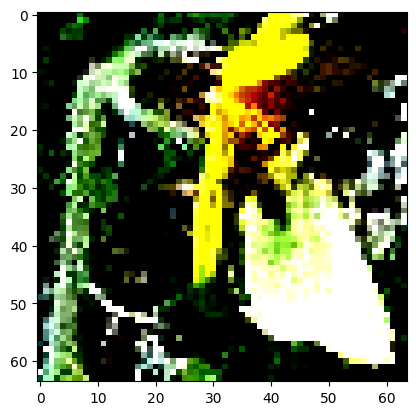

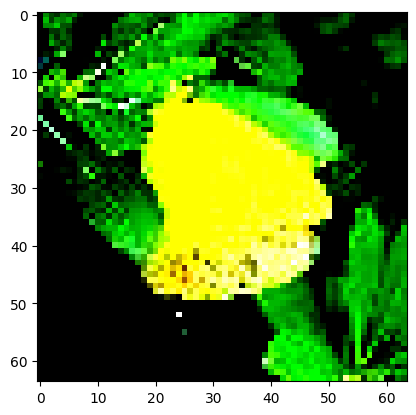

In [20]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

В итоге ничего не использовала, так как почти сразу решила импортировать не предобученную

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()

        pass

    def forward(self, x):

        return self.output(x)
        pass

    def forward(self, images, target=None):

       pass

    def get_accuracy(self, reset=False):
         #YOUR CODE HERE
       pass

### Тренировочный класс lightning

Цель была взять модель, про которую я просто когда-то слышала и все.... + я убрала сразу все с pretrained, тк такую нельзя было использовать

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, pretrained: bool = False) -> None:
        super().__init__()
        #
        self.model = torchvision.models.densenet201().to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters())

        self.loss = nn.CrossEntropyLoss()
        self.learning_rate = 0.022

    def forward(self, x) -> torch.Tensor:
            #
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        #accuracy = accuracy(task='multiclass', num_classes=200)
        acc = torchmetrics.functional.accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = "cuda" if torch.cuda.is_available() else "cpu"

#model = YourNet().to() # YOUR CODE HERE   нет, так как использовала не предобученную, но не свою
module = YourModule() # YOUR CODE HERE

In [ ]:
trainer = pl.Trainer(accelerator="cuda", max_epochs=16, logger=wandb_logger) # использовала 16 эпох
#trainer.tune(module, train_dataloader, val_dataloader) не смогла сделать auto_lr((((

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module, train_dataloader, val_dataloader)

wandb: Currently logged in as: juliachirkova. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | DenseNet         | 20.0 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
20.0 M    Trainable params
0         Non-trainable params
20.0 M    Total params
80.056    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


Отсюда уже видно, что accuracy>0.44🥰

jolly-bee3, batch 128, shuffle False, lr = 0.01


dutiful-snowball-4 batch 128, num_workers = 2, lr=0.02

In [ ]:
#logical firebrand с аугмент, lr=0.013

In [ ]:
   #deft-music-7 lr=0.022, c аугмент

### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=True)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy
    #выдавала ошибку, поэтому верная функция ниже

In [ ]:
from sklearn.metrics import accuracy_score
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model.forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [ ]:
checkpoint_reference="juliachirkova/lightning_logs/model-8p5xw1cg:v15" #импортировала из артефактов в wandb
run = wandb.init(project='lightning_logs')
artifact = run.use_artifact(checkpoint_reference, type='model')
artifact_dir = artifact.download()
model = YourModule.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

accuracy,▁▂▄▅▅▆▆▇▆▇▇█████
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss,█▇▆▆▆▆▅▅▄▄▄▄▄▄▃▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▆▅▄▃▃▆▂▃▁▁▁▁▁▁▁
accuracy,0.4471
epoch,15
train_loss,1.50464
trainer/global_step,12511
val_loss,2.50239


wandb: Downloading large artifact model-8p5xw1cg:v15, 230.85MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4
100%|██████████| 79/79 [00:06<00:00, 12.11it/s]

Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

Ресайзнула под обучаемую модель, потому что был проведен ресерч и эта модель (vit_l_16), будто бы лучше работает.

In [20]:
train_transform = albumentations.Compose([
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1),
                          albumentations.Rotate(p=1),
                          albumentations.ShiftScaleRotate(p=1)
    ], p=1),
    albumentations.augmentations.geometric.resize.Resize(224, 224),
    albumentations.Normalize(means, stds),
    albumentations.pytorch.transforms.ToTensorV2()
])

val_transform = albumentations.Compose([
    albumentations.augmentations.geometric.resize.Resize(224, 224),
    albumentations.Normalize(meansval, stdsval),
    albumentations.pytorch.transforms.ToTensorV2()
])

train_dataset = AlbumentationsImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = AlbumentationsImageFolder('dataset/dataset/val', transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        pass

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        pass

    def forward(self, images, target=None):
        # YOUR CODE HERE
        pass

    def get_accuracy(self, reset=False):
        # YOUR CODE HERE
        pass

### Тренировочный класс lightning

In [21]:
from torchmetrics.functional import accuracy

In [24]:
class YourModule(pl.LightningModule):
    def __init__(self, pretrained: bool = False) -> None:
        super().__init__()
        self.pretrained = pretrained

        if pretrained:
            #
            self.model = torchvision.models.vit_l_16(weights='IMAGENET1K_V1').to(device)
            self.model.fc = nn.Identity()
            self.classifier = nn.Linear(1000, 200) # т.к. 200 классов
            self.optimizer = torch.optim.AdamW(self.classifier.parameters(),lr=0.001, weight_decay=0.05)
        else:
            #
            self.model = torchvision.models.densenet201().to(device)
            self.optimizer = torch.optim.Adam(self.model.parameters())

        self.loss = nn.CrossEntropyLoss()
        self.learning_rate = 0.15

    def forward(self, x) -> torch.Tensor:
        if self.pretrained:
            #
            with torch.no_grad():
                features = self.model(x)
            preds = self.classifier(features)
        else:
            #
            preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [25]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning

#model = YourNet().to() # YOUR CODE HERE
module = YourModule(pretrained=True) # YOUR CODE HERE

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [00:15<00:00, 76.7MB/s]


In [26]:
trainer = pl.Trainer(accelerator="cuda", max_epochs=5, logger=wandb_logger)  # YOUR CODE HERE
trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | model      | VisionTransformer | 304 M 
1 | classifier | Linear            | 200 K 
2 | loss       | CrossEntropyLoss  | 0     
-------------------------------------------------
304 M     Trainable params
0         Non-trainable params
304 M     Total params
1,218.107 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


Остановила, потому что уже 0.842 и уже как будто хватит обучать (3 часа я устала)

### Валидация результатов задания

In [27]:
def evaluate_task(module, test_dataloader, device="cuda:0"):
    module = module.to(device)
    module.eval()
    accr = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            #loss = model(images, labels)
            acc_batch = accuracy(torch.argmax(module.forward(images), dim=-1).long(), labels.long(), task='multiclass', num_classes=200)
        accr += acc_batch
    accr = accr / len(test_dataloader)
    return accr.cpu()

In [29]:
#model = # Подгрузить свою сохраненную модель сюда

accr = evaluate_task(module, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accr - 0.5) / 0.34, 0, 10):.2f} баллов")


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

100%|██████████| 79/79 [05:20<00:00,  4.06s/it]

Оценка за это задание составит 10.00 баллов


# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

1 задание: слетела сначала память и случайно запускала модели в другом аккаунте wandb (мой младший брат удивился письмам на почту от weight and biases), https://wandb.ai/chirkovyrua19/lightning_logs?workspace=user-chirkovyrua19 -- здесь все с исходным кодом аугментаций без ресайза!



Далее в первом задании в ResNet201 (сразу взяла, не стала себе мозги делать, просто документация понравилась🥰), сделала потом аугментации с помощью библиотеки и поигралась с lr, поэтому полетело (в проекте есть подписанное, там в самом начале)
https://wandb.ai/juliachirkova/lightning_logs?workspace=user-juliachirkova

Во втором задании почти сразу пришла идея взять vit_l_16, потому что более легкие версии не прошли и выдавали плохое качество, а первая версия слетела (все есть в предыдущей ссылке!)

у меня слетела модель и я не смогла загрузить до дедлайна, поэтому пришлось ждать час (слетевшая модель по второму заданию есть в wandb!!), так что очень извиняюсь(

Хорошего дня и крепких нервов при проверке домашек🐣